In [66]:
import torch
import librosa
import os
import numpy as np
import pandas as pd

from utils import midi

%matplotlib ipympl
from matplotlib import pyplot as plt
import IPython.display as ipd

# TODO
1. fuse info from midi and pitch detection to enhance midi:
    - push note-on back in time, if previous frames detected same pitch as note
    - push note-off forward in time, if following frames detected same pitch as note
    - make sure new on/off does not intersect with other notes (if yes, fix other notes start/end)

# Load data

In [99]:
home_dir = os.environ['HOME']
data_dir = f'{home_dir}/ssynth/git_repos/DeepLearningExamples/PyTorch/SpeechSynthesis/HiFiGAN/data_ssynth'
phrase_df = pd.read_csv(f'{data_dir}/phrase_df.csv', index_col = 0).reset_index(drop = True)

#fnm = '01_Free_Improv_dynamic_mic_phrase014' #'01_Free_Improv_dynamic_mic_phrase000'
fnm = '01_Free_Improv_dynamic_mic_phrase007'
pinfo = phrase_df[phrase_df.phrase_id == fnm].iloc[0]
wav_fnm = f'{data_dir}/wavs/{fnm}.wav'
seg, sr = librosa.load(wav_fnm, sr = None)

env, pitch_hz, vprobv, vflag = torch.load(f'cache/{fnm}.pt')
times = librosa.times_like(env, sr = sr, hop_length = 256)

pitch = librosa.hz_to_midi(pitch_hz)
pitch_q = np.round(pitch)
pitch_env = pitch - pitch_q

#--- midi
file_id =  fnm.split('_phrase')[0] #wav_fnm.split('.')[0] # '01_Free_Improv_dynamic_mic'
midi_fnm = f'{data_dir}/auto_midi/{file_id}.mid'
print(f'reading midi file {os.path.basename(midi_fnm)}')
midi_df, midi_pitch, midi_aftertouch, midi_cc = midi.read_midi_to_df(midi_fnm)
midi.verify_midi(midi_df)
t0 = pinfo.sample_start / sr
midi_p = midi.midi_phrase_from_dataframe(pinfo, midi_df, sr)

reading midi file 01_Free_Improv_dynamic_mic.mid


## Try to "unwrap" the pitch envelope
#### **Note** this needs more investigation, at some notes it works and in some not

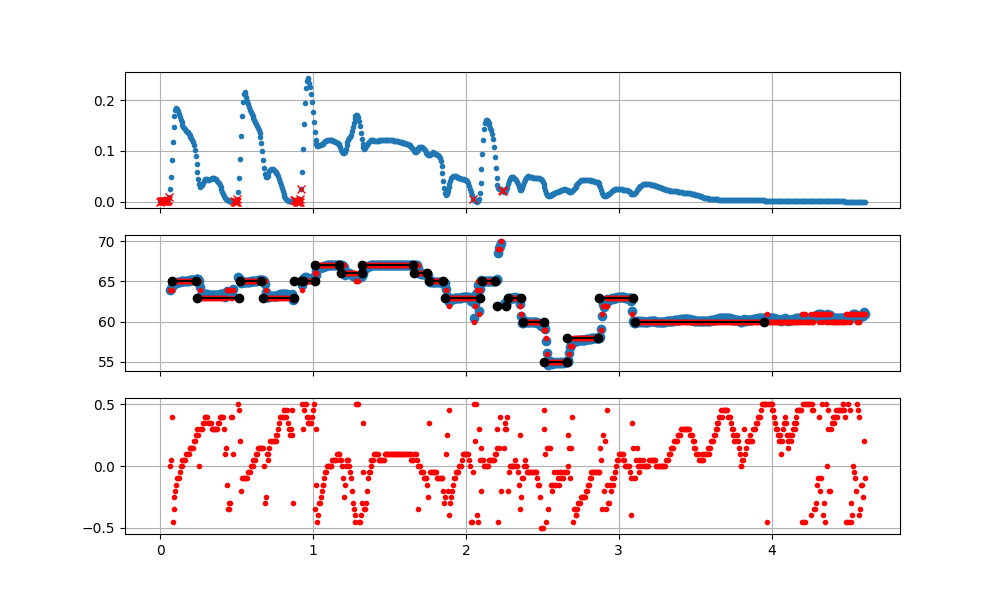

In [100]:
plt.close('all')
fig, ax = plt.subplots(3,1,sharex=True)
#ax[0].plot(time, seg, '.')
ax[0].plot(times, env, '.')
ax[0].plot(times[~vflag], env[~vflag], 'rx')
ax[0].grid()

ax[1].plot(times, pitch, 'o')
#ax[1].plot(times, pitch_uw, 'gx')
ax[1].plot(times, pitch_q, 'r.')
for irow, row in midi_p.iterrows():
    if row.type == 'note_off':
        continue
    note_on = row
    note_off = midi_p.loc[irow + 1]
    ax[1].plot([note_on.ts_sec - t0, note_off.ts_sec - t0], [note_on.note, note_on.note], 'ko-')
    
ax[1].grid()

#ax[2].plot(times, pitch_env_uw, 'gx')
ax[2].plot(times, pitch_env, 'r.')
ax[2].grid()

fig.set_size_inches(10,6)

ipd.Audio(data = seg, rate = sr / 2)

In [86]:
plt.close('all')